In [1]:
#MNIST pair of digits recognition using Softmax regression from scratch
#Yi Cong Li (20122756)
#this code is built using inpirations from Lab 1,2,3 and my existing project for Kaggle competition Weather-detect last year
#please make sure to run this code in default kaggle notebook environnment of competition

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt # plot for result analysis
import time # time the process

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


#helper functions

#function calculating confusion matrix
def conf_matrix(y_test, y_pred):

    n_classes = int(max(y_test))
    matrix = np.zeros((n_classes,n_classes))

    for (test, pred) in zip(y_test, y_pred):
        matrix[test-1, pred-1] += 1

    return matrix

#function returning softmax of x
def softmax(x):

    e = np.exp(x- np.max(x, axis=1, keepdims=True)) # minus the maximum for numerical stability

    return e / np.sum(e, axis=1, keepdims=True)

#function returning onehot encodage of y
def one_hot(y):
    
    l = len(y)
    y_hot = np.zeros((l, len(np.unique(y))))
    
    y_hot[np.arange(l), y] = 1
    
    return y_hot

#function calculating accuracy (similarity between labels and predictions)
def compute_accuracy(y_test, pred):
    return np.sum(y_test == pred) / len(y_test)


#loading train/val data
train_data_path = '/kaggle/input/classification-of-mnist-digits/train.csv'
df = pd.read_csv(train_data_path)
#drop the useless feature
df = df.drop(['Unnamed: 1568'], axis = 1)
X_data = df.values.astype(np.float32)


#loading test data
test_data_path = '/kaggle/input/classification-of-mnist-digits/test.csv'
df_test = pd.read_csv(test_data_path)
#drop the useless feature
df_test = df_test.drop(['Unnamed: 1568'], axis = 1)
X_test = df_test.values.astype(np.float32)

#loading train/val labels
train_labels_path = '/kaggle/input/classification-of-mnist-digits/train_result.csv'
df_train_labels = pd.read_csv(train_labels_path)
y_data = df_train_labels['Class'].to_numpy()

#split train set and validation set randomly using seed 6390, 80% train, 20% validation
np.random.seed(6390)
len_train = round(0.80*X_data.shape[0])
idx = np.arange(X_data.shape[0])
np.random.shuffle(idx)

#train set
train_idx = idx[:len_train]
X_train = X_data[train_idx] 
y_train = y_data[train_idx]

#validation set
val_idx = idx[len_train:]
X_val = X_data[val_idx]
y_val = y_data[val_idx]


/kaggle/input/classification-of-mnist-digits/train_result.csv
/kaggle/input/classification-of-mnist-digits/train.csv
/kaggle/input/classification-of-mnist-digits/test.csv


In [2]:
"""
#Oversampling trainset
df_train_X = pd.DataFrame(X_train)
df_train_y = pd.DataFrame(y_train)

df_train_data = df_train_X.copy()
df_train_data['class'] = df_train_y
freq_list = df_train_data['class'].value_counts()
nb_max_samples = freq_list.max()
for i in range(19):
    subset = df_train_data[df_train_data['class'] == i].copy()
    ratio = np.floor(nb_max_samples / freq_list[i]).astype('int')
    if ratio > 1:
        df_train_data = df_train_data.append([subset]*(ratio-1),ignore_index=True)
    subset = df_train_data[df_train_data['class'] == i].copy()
    diff = nb_max_samples - subset.shape[0]
    df_train_data = df_train_data.append(subset.iloc[:diff,:])
df_train_data = df_train_data.sample(frac=1)
df_X_train = df_train_data.copy().drop(['class'], axis = 1)
X_train = df_X_train.to_numpy()
df_y_train = df_train_data.copy()['class']
y_train = df_y_train.to_numpy()
"""
#Code above is for oversampling from scratch, however the model performed worse after this naive oversampling, probably that
#Softmax weight matrix overfitting some of the oversampled data, since they are simply duplications. Therefore, this part removed.

"\n#Oversampling trainset\ndf_train_X = pd.DataFrame(X_train)\ndf_train_y = pd.DataFrame(y_train)\n\ndf_train_data = df_train_X.copy()\ndf_train_data['class'] = df_train_y\nfreq_list = df_train_data['class'].value_counts()\nnb_max_samples = freq_list.max()\nfor i in range(19):\n    subset = df_train_data[df_train_data['class'] == i].copy()\n    ratio = np.floor(nb_max_samples / freq_list[i]).astype('int')\n    if ratio > 1:\n        df_train_data = df_train_data.append([subset]*(ratio-1),ignore_index=True)\n    subset = df_train_data[df_train_data['class'] == i].copy()\n    diff = nb_max_samples - subset.shape[0]\n    df_train_data = df_train_data.append(subset.iloc[:diff,:])\ndf_train_data = df_train_data.sample(frac=1)\ndf_X_train = df_train_data.copy().drop(['class'], axis = 1)\nX_train = df_X_train.to_numpy()\ndf_y_train = df_train_data.copy()['class']\ny_train = df_y_train.to_numpy()\n"

epoch 0, loss = 2.9748336633637775, accuracy = 0.0524, accuracy_val = 0.0913
epoch 100, loss = 2.481951278648489, accuracy = 0.1812, accuracy_val = 0.1675
epoch 200, loss = 2.387711542188063, accuracy = 0.207325, accuracy_val = 0.1872
epoch 300, loss = 2.3374084302481175, accuracy = 0.21815, accuracy_val = 0.1916
epoch 400, loss = 2.3045082318509915, accuracy = 0.225175, accuracy_val = 0.1949
epoch 500, loss = 2.2806609384375345, accuracy = 0.230025, accuracy_val = 0.1969
epoch 600, loss = 2.2622384649429286, accuracy = 0.234375, accuracy_val = 0.1996
epoch 700, loss = 2.247376181357362, accuracy = 0.237525, accuracy_val = 0.2012
epoch 800, loss = 2.235005484105873, accuracy = 0.2402, accuracy_val = 0.2029
epoch 900, loss = 2.224464005576953, accuracy = 0.2435, accuracy_val = 0.2035
epoch 1000, loss = 2.2153160094432156, accuracy = 0.246025, accuracy_val = 0.2039
epoch 1100, loss = 2.2072611522446435, accuracy = 0.248375, accuracy_val = 0.2052
epoch 1200, loss = 2.200084494759923, accu

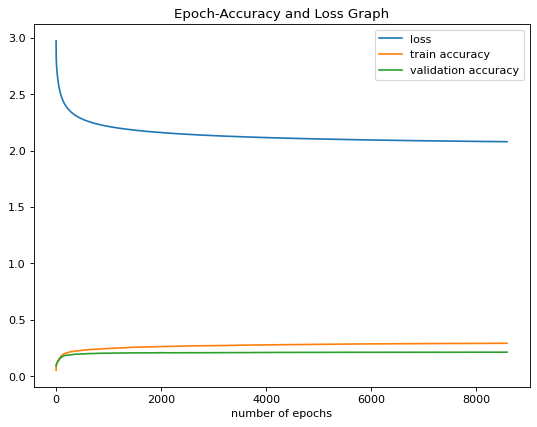

In [3]:
#model of softmax regression
class SoftmaxRegression():
    
    #initialize with number of epochs, learning rate and L2 regularizer coefficient
    #parameters are initialized with values determined by exhaustive trials (naive hyperparameter tunning)
    def __init__(self, epochs=8585, lr=0.1, reg = 1e-4):
        self.epochs = epochs
        self.lr = lr
        self.reg = reg

    #train model with X, y of train set, use X_val, y_val to chose near best parameters according to validation accuracy
    def train(self, X, y, X_val, y_val):
        
        #lists to store accuracies and losses
        accuracies = []
        accuracies_val = []
        losses = []
        
        #augment bias parameter to X
        X = np.insert(X, 0, 1, axis=1)
        X_val = np.insert(X_val, 0, 1, axis=1)

        #glorot initialization for theta
        limit = np.sqrt(2 / X.shape[1])
        np.random.seed(6395)
        self.theta = np.random.uniform(-limit, limit, (X.shape[1], len(np.unique(y))))

        start = time.time()
        #batch gradient descent with epochs
        for epoch in range(self.epochs):
            
            #softmax to predict the probabilities of each data point to belong to each class
            y_preds = softmax(X.dot(self.theta))
            #loss function (cross entropy) with L2 regularization (squared theta)
            loss = -np.mean(np.log(y_preds[np.arange(len(y)), y])) + self.reg*1/(len(y))*np.sum(self.theta**2)
            gradient = (1/X.shape[0])*X.T.dot(y_preds - one_hot(y))
            # Update theta with L2 regularizer
            self.theta -= self.lr * gradient + self.reg*self.theta
            
            #predictions on train set
            preds = np.argmax(y_preds, axis=1)
            
            #predictions on validation set
            y_preds_val = softmax(X_val.dot(self.theta))
            preds_val = np.argmax(y_preds_val, axis=1)
            
            #accuracy of train prediction and validation prediction
            accuracy = compute_accuracy(y, preds)
            accuracy_val = compute_accuracy(y_val, preds_val)
            
            #information printed to observe if loss and error decrease during the process
            losses.append(loss)
            accuracies.append(accuracy)
            accuracies_val.append(accuracy_val)
            if epoch % 100 == 0:
                print('epoch {epoch}, loss = {loss}, accuracy = {accuracy}, accuracy_val = {accuracy_val}'
                      .format(epoch=epoch, loss=loss, accuracy=accuracy, accuracy_val=accuracy_val))
        end = time.time()

        #information printed for best epochs (highest validation accuracy) within the epochs choosen 
        print(' best accuracy_val = ', 
              np.max(accuracies_val), 
              ' epochs of first occurence of this accuracy_val = ', 
              np.argmax(accuracies_val),
              ' time used = ', str((end - start)/60/60) + 'hour')
        len_epochs = np.arange(self.epochs)
        
        plt.figure(figsize= (8,6),dpi=80)
        plt.title('Epoch-Accuracy and Loss Graph')
        plt.plot(len_epochs, losses, label = "loss")
        plt.plot(len_epochs, accuracies, label = "train accuracy")
        plt.plot(len_epochs, accuracies_val, label = "validation accuracy")
        plt.xlabel("number of epochs")
        plt.legend()
        plt.show
        return self

    #make prediction
    def predict(self, X):
        
        #augment bias.
        X = np.insert(X, 0, 1, axis=1)

        #predicted probabilities (sum to 1) for each sample to belong to each class
        y_preds = softmax(X.dot(self.theta))

        #return class of highest probability
        return np.argmax(y_preds, axis=1)


#train model and predict test set.
model = SoftmaxRegression()
model.train(X_train, y_train, X_val, y_val)
preds_val = model.predict(X_val)
preds_train = model.predict(X_train)
#compute accuracy rates of predictions.
accuracy_rate_val = compute_accuracy(y_val, preds_val)
accuracy_rate_train = compute_accuracy(y_train, preds_train)
    
confmat = conf_matrix(y_val, preds_val)
    
print('confusion matrix is:')
print(confmat)
    
preds_result = model.predict(X_test)
print('Result accuracy_val = ',accuracy_rate_val)
print('Result accuracy_train = ',accuracy_rate_train)
    

output = pd.DataFrame({'Index': np.arange(X_test.shape[0]), 'Class': preds_result})
output.to_csv('submission.csv', index=False)
